In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
import arviz as az
import scipy.stats.kde as kde

# Generate files for stan program

In [2]:
# control parameters
diet = 'Resistant starch'
abundance_type = 'absolute'
taxonomy_level = 'species'
topN_taxa = 20

In [3]:
# read meta data
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[(df_meta.Diet==diet) | (df_meta.Diet=='Control')]
df_meta['Diet'] = [1 if g==diet else 0 for g in df_meta['Diet']]

# read bacterial absolute abundance
df_bac = pd.read_csv('../../../our_data/16S_%s_abundance_%s.csv'%(abundance_type,taxonomy_level), index_col=0)

# replace unsupported characters with text descriptions
df_bac.columns = [c.replace('/','_slash_').replace(' ','_space_').replace('[','_leftsquarebracket_').replace(']','_rightsquarebracket_').replace('-','_dash_').replace('.','_dot_').replace('(','_leftroundbracket').replace(')','_rightroundbracket_') for c in df_bac.columns]

# replace zeros with minimum non-zero values (since these values will be log-tranformed later)
for sample_id in df_bac.index:
    sample = np.array(df_bac.loc[sample_id])
    minval = np.min(sample[np.nonzero(sample)]) # minimum non-zero value
    sample[sample==0] = minval
    df_bac.loc[sample_id] = sample
df_bac.head()

# select the most abundant species
df_bac_T = df_bac.loc[df_meta.index].T
df_bac_T['mean'] = df_bac_T.mean(axis=1)
df_bac_T = df_bac_T.sort_values(by=['mean'],axis=0,ascending=False)
df_bac_T = df_bac_T.drop('mean', axis=1)
df_bac_topN_taxa = df_bac_T.iloc[0:topN_taxa].T
selected_bacterial_taxa = list(df_bac_topN_taxa.columns)

# normalize max abosolute value to 1
normalization_factor = df_bac_topN_taxa.max().max()
df_bac_topN_taxa = df_bac_topN_taxa/normalization_factor

# merge metadata and bacterial abundance
df_bac_topN_taxa_w_meta = pd.merge(df_meta, df_bac_topN_taxa, left_index=True, right_index=True, how='inner')

# calculate derivative of bacterial abundance
df_deriv = deepcopy(df_bac_topN_taxa_w_meta)
for curr_mice in set(df_deriv.MiceID):
    curr_df = df_deriv[df_deriv.MiceID==curr_mice]
    for taxon in selected_bacterial_taxa:
        xdata = np.array(curr_df['Day'])
        ydata = np.array(curr_df[taxon])
        cs = CubicSpline(xdata, ydata)
        csd1 = cs.derivative(nu=1)
        ydata_d1 = csd1(xdata)
        df_deriv.loc[df_deriv.MiceID==curr_mice, taxon] = ydata_d1

# construct regression matrix (Y~X)
Ymat = df_deriv[selected_bacterial_taxa].values # Ymat should be samples by bacteria
Ymat = Ymat.flatten(order='F')
Ymat = StandardScaler().fit_transform(Ymat.reshape(-1,1)).reshape(1,-1)[0] # standardize

Xmat = np.zeros(shape=(topN_taxa*len(df_deriv.index), (topN_taxa+2)*topN_taxa))
for k in np.arange(topN_taxa):
    Xmat[k*len(df_deriv.index):(k+1)*len(df_deriv.index),k*(topN_taxa+2)] = 1
    Xmat[k*len(df_deriv.index):(k+1)*len(df_deriv.index),k*(topN_taxa+2)+1] = df_deriv.Diet.values
    Xmat[k*len(df_deriv.index):(k+1)*len(df_deriv.index),k*(topN_taxa+2)+2:(k+1)*(topN_taxa+2)] = df_bac_topN_taxa_w_meta[selected_bacterial_taxa].values

# write data file
json_str = '{\n"N" : %d,\n'%(len(Ymat))
json_str += '\"dlogX\" : [%s],\n'%(','.join(list(Ymat.astype(str)))) # y variable
for k1,c1 in enumerate(selected_bacterial_taxa): # x variable
    # growth rate
    json_str += '\"growth_rate_%s\" : [%s],\n'%(c1,','.join(list(Xmat[:,k1*(topN_taxa+2)].astype(str))))
    # diet response
    json_str += '\"rs_response_%s\" : [%s],\n'%(c1,','.join(list(Xmat[:,k1*(topN_taxa+2)+1].astype(str))))
    # bacterial interactions
    for k2,c2 in enumerate(selected_bacterial_taxa):
        v = list(Xmat[:,k1*(topN_taxa+2)+2+k2].astype(str))
        json_str += '\"pairwise_interaction_%s_%s\" : [%s]'%(c1,c2,','.join(v))
        if c1 == selected_bacterial_taxa[-1] and c2 == selected_bacterial_taxa[-1]:
            json_str += '\n}'
        else:
            json_str += ',\n'

text_file = open("%s_mice_%s_abundance_top%d_%s.data.json"%(diet, abundance_type, topN_taxa, taxonomy_level), "w")
text_file.write("%s" % json_str)
text_file.close()

# write model file
# data block
model_str = 'data {\n'
model_str += '\tint<lower=0> N;\n'
model_str += '\tvector[N] dlogX;\n'
for c1 in selected_bacterial_taxa:
    model_str += '\tvector[N] growth_rate_%s;\n'%(c1)
    model_str += '\tvector[N] rs_response_%s;\n'%(c1)
    for c2 in selected_bacterial_taxa:
        model_str += '\tvector[N] pairwise_interaction_%s_%s;\n'%(c1,c2)
model_str += '}\n'

# parameter block
model_str += 'parameters {\n\treal<lower=0,upper=1> sigma;\n'
for c1 in selected_bacterial_taxa:
    model_str += '\treal alpha__%s;\n'%(c1) # growth rate
    model_str += '\treal epsilon__%s;\n'%(c1) # resistant_starch response
    for c2 in selected_bacterial_taxa:
        model_str += '\treal beta__%s_%s;\n'%(c1,c2)
model_str += '}\n'       
        
# model block
model_str += 'model {\n\tsigma ~ uniform(0,1);\n'
for c1 in selected_bacterial_taxa:
    model_str += '\talpha__%s ~ normal(0,1);\n'%(c1) # growth rate
    model_str += '\tepsilon__%s ~ normal(0,1);\n'%(c1) # resistant_starch response
    for c2 in selected_bacterial_taxa:
        model_str += '\tbeta__%s_%s ~ normal(0,1);\n'%(c1,c2)
model_str += '\tdlogX ~ normal('
for c1 in selected_bacterial_taxa:
    model_str += 'alpha__%s*growth_rate_%s+'%(c1,c1) # growth rate
    model_str += 'epsilon__%s*rs_response_%s+'%(c1,c1) # resistant_starch response
    for c2 in selected_bacterial_taxa:
        if c1 == selected_bacterial_taxa[-1] and c2 == selected_bacterial_taxa[-1]:
            model_str += 'beta__%s_%s*pairwise_interaction_%s_%s'%(c1,c2,c1,c2)
        else:
            model_str += 'beta__%s_%s*pairwise_interaction_%s_%s+'%(c1,c2,c1,c2)
model_str += ', sigma);\n}'

text_file = open("%s_mice_%s_abundance_top%d_%s.stan"%(diet, abundance_type, topN_taxa, taxonomy_level), "w")
text_file.write("%s" % model_str)
text_file.close()

# Read stan output and generate summary table

In [4]:
def hpd_grid(sample, alpha=0.05, roundto=2):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI). 
    The function works for multimodal distributions, returning more than one mode
    Parameters
    ----------
    
    sample : Numpy array or python list
        An array containing MCMC samples
    alpha : float
        Desired probability of type I error (defaults to 0.05)
    roundto: integer
        Number of digits after the decimal point for the results
    Returns
    ----------
    hpd: array with the lower 
          
    """
    sample = np.asarray(sample)
    sample = sample[~np.isnan(sample)]
    # get upper and lower bounds
    l = np.min(sample)
    u = np.max(sample)
    density = kde.gaussian_kde(sample)
    x = np.linspace(l, u, 2000)
    y = density.evaluate(x)
    #y = density.evaluate(x, l, u) waitting for PR to be accepted
    xy_zipped = zip(x, y/np.sum(y))
    xy = sorted(xy_zipped, key=lambda x: x[1], reverse=True)
    xy_cum_sum = 0
    hdv = []
    for val in xy:
        xy_cum_sum += val[1]
        hdv.append(val[0])
        if xy_cum_sum >= (1-alpha):
            break
    hdv.sort()
    diff = (u-l)/20  # differences of 5%
    hpd = []
    hpd.append(round(min(hdv), roundto))
    for i in range(1, len(hdv)):
        if hdv[i]-hdv[i-1] >= diff:
            hpd.append(round(hdv[i-1], roundto))
            hpd.append(round(hdv[i], roundto))
    hpd.append(round(max(hdv), roundto))
    ite = iter(hpd)
    hpd = list(zip(ite, ite))
    modes = []
    for value in hpd:
        x_hpd = x[(x > value[0]) & (x < value[1])]
        y_hpd = y[(x > value[0]) & (x < value[1])]
        modes.append(round(x_hpd[np.argmax(y_hpd)], roundto))
    return hpd, x, y, modes

In [33]:
fit = az.from_cmdstan(["stan_output_%d_raw_%s_abundance_top%d_%s.csv"%(i,abundance_type,topN_taxa,taxonomy_level) for i in np.arange(1,4)])

lines = []
    
# basal growth rate
for c in selected_bacterial_taxa:
    var = 'alpha__%s'%(c)
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior[var][i].values))
    hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
    assert len(hpd_mu) == 1
    (x0, x1) = hpd_mu[0]
    lines.append(['basal_growth_rate', c, x0, x1, (x0+x1)/2, np.mean(data)/np.std(data), x0*x1>0])
    
# resistant starch response
for c in selected_bacterial_taxa:
    var = 'epsilon__%s'%(c)
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior[var][i].values))
    hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
    assert len(hpd_mu) == 1
    (x0, x1) = hpd_mu[0]
    lines.append(['rs_response', c, x0, x1, (x0+x1)/2, np.mean(data)/np.std(data), x0*x1>0])

# pairwise interactions
for c1 in selected_bacterial_taxa:
    for c2 in selected_bacterial_taxa:
        var = 'beta__%s_%s'%(c1,c2)
        data = []
        for i in np.arange(0,3):
            data.extend(list(fit.posterior[var][i].values))
        hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
        assert len(hpd_mu) == 1
        (x0, x1) = hpd_mu[0]
        lines.append(['pairwise_interaction', (c1,c2), x0, x1, (x0+x1)/2, np.mean(data)/np.std(data), x0*x1>0])
    
df_stan_output_summary = pd.DataFrame(lines, columns = ['Type','Taxa','Left','Right','Middle','SNR','Significant'])
df_stan_output_summary.to_excel('stan_output_summary_%s_abundance_top%d_%s.xlsx'%(abundance_type,topN_taxa,taxonomy_level))
df_stan_output_summary.head()

,Type,Taxa,Left,Right,Middle,SNR,Significant
0,basal_growth_rate,Muribaculaceae,-0.15,0.24,0.045,0.443050,False
1,basal_growth_rate,Faecalibaculum,-0.18,0.22,0.020,0.209583,False
2,basal_growth_rate,Bacteroides_dash_acidifaciens,-0.34,0.04,-0.150,-1.542393,False
3,basal_growth_rate,Lachnospiraceae_dash_NK4A136_dash_group,-0.25,0.14,-0.055,-0.590692,False
4,basal_growth_rate,Parabacteroides_dash_goldsteinii,-0.36,0.03,-0.165,-1.638676,False


# Show significant diet responders and species-species interactions

## absolute abundance, top20 species

In [6]:
df_stan_output_summary = pd.read_excel('stan_output_summary_absolute_abundance_top20_species.xlsx', index_col=0)
df_stan_output_summary = df_stan_output_summary[df_stan_output_summary.Significant==True]
df_stan_output_summary

,Type,Taxa,Left,Right,Middle,SNR,Significant
20,rs_response,Muribaculaceae,0.42,0.90,0.660,5.491318,True
21,rs_response,Faecalibaculum,0.85,1.32,1.085,8.986253,True
27,rs_response,Alloprevotella,-0.49,-0.02,-0.255,-2.153641,True
29,rs_response,Desulfovibrionaceae,0.17,0.65,0.410,3.338960,True
40,pairwise_interaction,"('Muribaculaceae', 'Muribaculaceae')",2.88,4.31,3.595,9.897982,True
41,pairwise_interaction,"('Muribaculaceae', 'Faecalibaculum')",-4.73,-1.85,-3.290,-4.506180,True
43,pairwise_interaction,"('Muribaculaceae', 'Lachnospiraceae_dash_NK4A1...",-5.85,-2.90,-4.375,-5.836662,True
48,pairwise_interaction,"('Muribaculaceae', 'Lachnospiraceae_dash_bacte...",-3.28,-0.39,-1.835,-2.509557,True
49,pairwise_interaction,"('Muribaculaceae', 'Desulfovibrionaceae')",-2.88,-0.11,-1.495,-2.125255,True
54,pairwise_interaction,"('Muribaculaceae', 'Lachnospiraceae_dash_bacte...",-3.75,-0.73,-2.240,-2.912772,True


# Plot posterior distribution of resistant starch responders

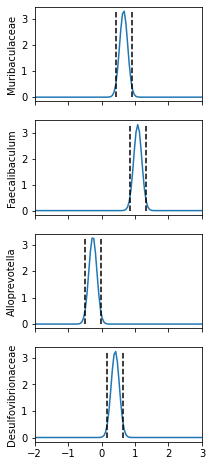

In [4]:
fit = az.from_cmdstan(["stan_output_%d_raw_absolute_abundance_top20_species.csv"%(i) for i in np.arange(1,4)])

# find resistant_starch responders
df_stan_output_summary = pd.read_excel('stan_output_summary_absolute_abundance_top20_species.xlsx', index_col=0)
df_stan_output_summary = df_stan_output_summary[df_stan_output_summary.Significant==True].reset_index(drop=True)
df_stan_output_summary = df_stan_output_summary[df_stan_output_summary.Type=='rs_response']

# plot
fig, ax = plt.subplots(figsize=(3,8), nrows=len(df_stan_output_summary.index), ncols=1, sharex=True)

for idx in df_stan_output_summary.index:
    _type = df_stan_output_summary.loc[idx,'Type']
    _taxa = df_stan_output_summary.loc[idx,'Taxa']
    _left = df_stan_output_summary.loc[idx,'Left']
    _middle = df_stan_output_summary.loc[idx,'Middle']
    _right = df_stan_output_summary.loc[idx,'Right']
    if _type == 'rs_response':
        var = 'epsilon__%s'%(_taxa)
    if _type == 'pairwise_interaction':
        var = 'beta__%s_%s'%(eval(_taxa)[0],eval(_taxa)[1])
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior[var][i].values))
    mean,std=norm.fit(data)
    x = np.linspace(-2, 3, 100)
    ax[idx].set_xlim([-2,3])
    y = norm.pdf(x, mean, std)
    ax[idx].plot(x,y)
    ax[idx].plot([_left,_left],[0,np.max(y)], 'k--')
    ax[idx].plot([_right,_right],[0,np.max(y)], 'k--')
    ax[idx].set_ylabel(_taxa)
    
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("posterior_distribution_resistant_starch_responders_absolute_abundance_top20_species.svg", format="svg")

# Plot relative abundance of 4 resistant starch responders on log scale

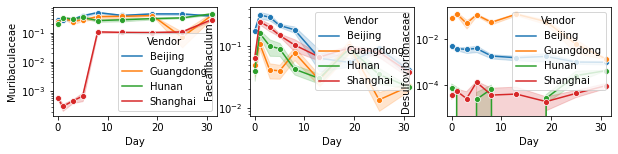

In [9]:
resistant_starch_responders = ['Muribaculaceae','Faecalibaculum','Desulfovibrionaceae']
fig, ax = plt.subplots(figsize=(10,2), nrows=1, ncols=len(resistant_starch_responders))

df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Resistant starch']
df_bac = pd.read_csv('../../../our_data/16S_relative_abundance_species.csv', index_col=0)
df_meta_bac = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

for k,ir in enumerate(resistant_starch_responders):
    sns.lineplot(x='Day',y=ir, marker='o', hue='Vendor', ci=68, data=df_meta_bac, ax=ax[k])
    ax[k].set_xlim([-1,32])
    ax[k].set_yscale('log')

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("time_series_resistant_starch_responder_relative_abundance_log_scale.svg", format="svg")

# Plot absolute abundance of 4 resistant starch responders on linear scale

## plot different responders in separate graphs

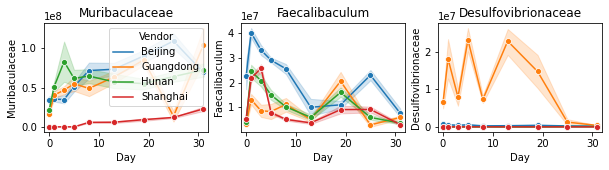

In [10]:
resistant_starch_responders = ['Muribaculaceae','Faecalibaculum','Desulfovibrionaceae']
fig, ax = plt.subplots(figsize=(10,2), nrows=1, ncols=len(resistant_starch_responders))

df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Resistant starch']
df_bac = pd.read_csv('../../../our_data/16S_absolute_abundance_species.csv', index_col=0)
df_meta_bac = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

for k,ir in enumerate(resistant_starch_responders):
    sns.lineplot(x='Day',y=ir, marker='o', hue='Vendor', ci=68, data=df_meta_bac, ax=ax[k])
    ax[k].set_xlim([-1,32])
    ax[k].set_title(ir)
    if k!=0:
        ax[k].legend().remove()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("time_series_resistant_starch_responder_separate_graph_absolute_abundance_linear_scale.svg", format="svg")

## plot different responders in the same graph

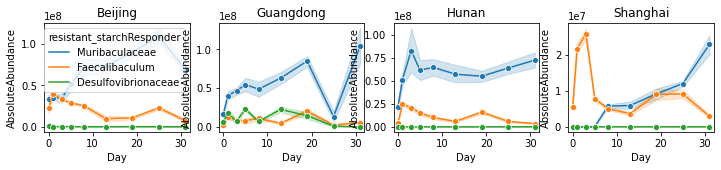

In [12]:
fig, ax = plt.subplots(figsize=(12,2), nrows=1, ncols=4)

df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Resistant starch']
df_bac = pd.read_csv('../../../our_data/16S_absolute_abundance_species.csv', index_col=0)
df_meta_bac = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

resistant_starch_responders = ['Muribaculaceae','Faecalibaculum','Desulfovibrionaceae']
for k,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    df_tmp = df_meta_bac.loc[df_meta_bac.Vendor==vendor,['Day']+resistant_starch_responders].set_index('Day').unstack().reset_index()
    df_tmp.columns = ['resistant_starchResponder','Day','AbsoluteAbundance']
    sns.lineplot(x='Day',y='AbsoluteAbundance', marker='o', hue='resistant_starchResponder', ci=68, data=df_tmp, ax=ax[k])
    ax[k].set_title(vendor)
    ax[k].set_xlim([-1,32])
    if k!=0:
        ax[k].legend().remove()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("time_series_resistant_starch_responder_same_graph_absolute_abundance_linear_scale.svg", format="svg")

## plot total relative abundance of all responders

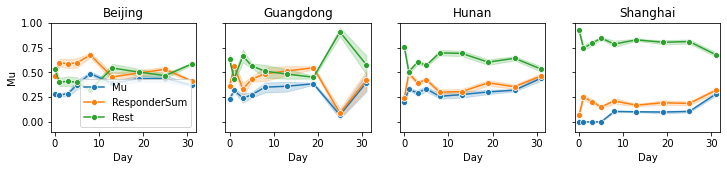

In [9]:
fig, ax = plt.subplots(figsize=(12,2), nrows=1, ncols=4, sharex=True, sharey=True)

df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Resistant starch']
df_bac = pd.read_csv('../../../our_data/16S_relative_abundance_species.csv', index_col=0)
df_meta_bac = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

resistant_starch_responders = ['Muribaculaceae','Faecalibaculum','Desulfovibrionaceae']
for k,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    df_tmp = df_meta_bac.loc[df_meta_bac.Vendor==vendor].set_index('Day',drop=True).drop(['Vendor','MiceID','Diet','RandomizedGroup'], axis=1)
    df_tmp['Rest'] = df_tmp[[c for c in df_tmp.columns if c not in resistant_starch_responders]].sum(axis=1) # do this first
    df_tmp['Mu'] = df_tmp[['Muribaculaceae']].sum(axis=1)
    df_tmp['ResponderSum'] = df_tmp[resistant_starch_responders].sum(axis=1)
    sns.lineplot(x='Day',y='Mu', marker='o', ci=68, data=df_tmp, ax=ax[k], label='Mu')
    sns.lineplot(x='Day',y='ResponderSum', marker='o', ci=68, data=df_tmp, ax=ax[k], label='ResponderSum')
    sns.lineplot(x='Day',y='Rest', marker='o', ci=68, data=df_tmp.reset_index(), ax=ax[k], label='Rest')
    ax[k].set_title(vendor)
    ax[k].set_xlim([-1,32])
    ax[k].set_xticks([0,10,20,30])
    ax[k].set_ylim([-0.1,1])
    if k!=0:
        ax[k].legend().remove()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("time_series_resistant_starch_responder_total_relative_abundance.svg", format="svg")

## plot total absolute abundance of all responders

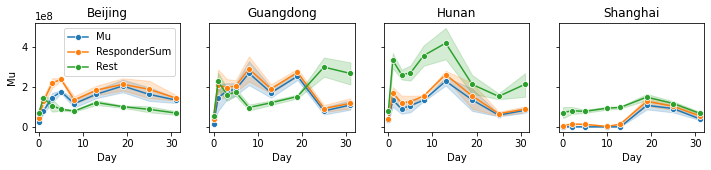

In [10]:
fig, ax = plt.subplots(figsize=(12,2), nrows=1, ncols=4, sharex=True, sharey=True)

df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']
df_bac = pd.read_csv('../../../our_data/16S_absolute_abundance_species.csv', index_col=0)
df_meta_bac = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

resistant_starch_responders = ['Muribaculaceae','Faecalibaculum']
for k,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    df_tmp = df_meta_bac.loc[df_meta_bac.Vendor==vendor].set_index('Day',drop=True).drop(['Vendor','MiceID','Diet','RandomizedGroup'], axis=1)
    df_tmp['Rest'] = df_tmp[[c for c in df_tmp.columns if c not in resistant_starch_responders]].sum(axis=1) # do this first
    df_tmp['Mu'] = df_tmp[['Muribaculaceae']].sum(axis=1)
    df_tmp['ResponderSum'] = df_tmp[resistant_starch_responders].sum(axis=1)
    sns.lineplot(x='Day',y='Mu', marker='o', ci=68, data=df_tmp.reset_index(), ax=ax[k], label='Mu')
    sns.lineplot(x='Day',y='ResponderSum', marker='o', ci=68, data=df_tmp.reset_index(), ax=ax[k], label='ResponderSum')
    sns.lineplot(x='Day',y='Rest', marker='o', ci=68, data=df_tmp.reset_index(), ax=ax[k], label='Rest')
    ax[k].set_title(vendor)
    ax[k].set_xlim([-1,32])
    ax[k].set_xticks([0,10,20,30])
    if k!=0:
        ax[k].legend().remove()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("time_series_resistant_starch_responder_total_absolute_abundance.svg", format="svg")

# plot total absolute abundance of all responders

22


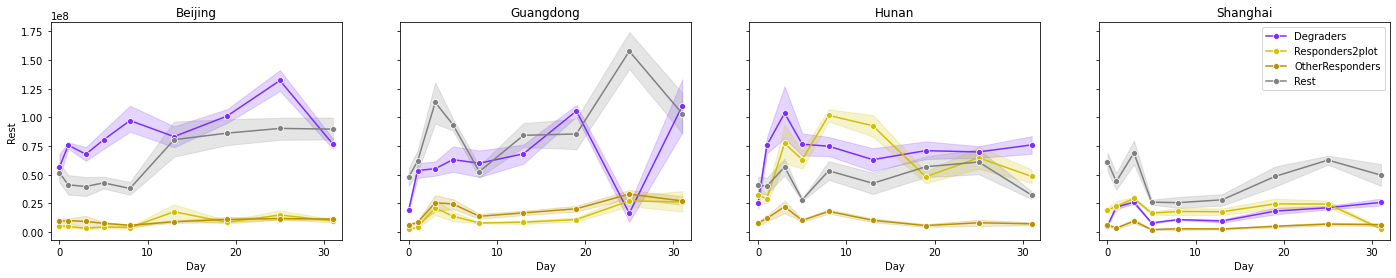

In [10]:
fig, ax = plt.subplots(figsize=(24,4), nrows=1, ncols=4, sharex=True, sharey=True)

df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Resistant starch']
df_bac = pd.read_csv('../../../our_data/16S_absolute_abundance_species.csv', index_col=0)
df_meta_bac = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

degraders = ['Muribaculaceae','Faecalibaculum']
responders_toplot = ['Lachnospiraceae-NK4A136-group','Bacteroides-acidifaciens','Parabacteroides-goldsteinii']
df_other_responders = pd.read_csv('../../figure4_individualized_response/resistant_starch/individualized_response_bacteria_species_absolute_abundance.csv', index_col=0)
df_other_responders = df_other_responders[(df_other_responders.P_rsp_corrected<0.05)&(df_other_responders.meanAbsab_ratio>1)]
other_responders = list(set(df_other_responders.Variable)-set(degraders)-set(responders_toplot))
print(len(other_responders))

colors = ['#7A2EFF','#D0C100','#B99200','#808080']
for k,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    df_tmp = df_meta_bac.loc[df_meta_bac.Vendor==vendor].set_index('Day',drop=True).drop(['Vendor','MiceID','Diet','RandomizedGroup'], axis=1)
    if vendor=='Guangdong':
        #assert 0
        pass
    df_tmp['Rest'] = df_tmp[[c for c in df_tmp.columns if c not in degraders and c not in responders_toplot and c not in other_responders]].sum(axis=1) # do this first
    df_tmp['OtherResponders'] = df_tmp[other_responders].sum(axis=1)
    df_tmp['Responders2plot'] = df_tmp[responders_toplot].sum(axis=1)
    df_tmp['Degraders'] = df_tmp[degraders].sum(axis=1)
    for kr, r in enumerate(['Degraders','Responders2plot','OtherResponders','Rest']):
        sns.lineplot(x='Day',y=r, marker='o', ci=68, data=df_tmp.reset_index(), ax=ax[k], label=r, color=colors[kr])
    ax[k].set_title(vendor)
    ax[k].set_xlim([-1,32])
    ax[k].set_xticks([0,10,20,30])
    if k!=3:
        ax[k].legend().remove()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("time_series_inulin_responder_total_absolute_abundance.svg", format="svg")